In [2]:
from helpers import *
from sklearn.cluster import KMeans
import pickle


features = get_available_features()

n = 50


def kmeansnclusters(k, seed=0):
    feat = get_available_features()
    data = get_prediction_dataset(feat, "family")

    family_counts = data['family'].value_counts()
    families_to_replace = family_counts[family_counts < 5].index

    # Replace the family label with "rest" for these families
    data['family'] = data['family'].apply(lambda x: 'rest' if x in families_to_replace else x)

    epsilon = 1e-12
    data[features] = (data[features] - data[features].mean()) / (data[features].std() + epsilon)

    data_train, data_test = train_test_split(data, test_size=0.2, random_state=seed, stratify=data["family"])

    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(data_train[features])


    data_train['cluster'] = kmeans.labels_
    #cluster_assignment = pd.DataFrame(list(zip(data_train['hash'].tolist(), kmeans.labels_)), columns= ["hash", "cluster"])


    configsIndeces = minhitset(data_train, 10, seed=seed, target = "cluster")
    df = pd.read_csv('top40.csv')
    df = df.groupby('configuration')['time'].sum()

    configs = df.iloc[configsIndeces].index.tolist()

    cluster_config= {}
    for cluster in range(k):

        df = pd.read_csv('top40.csv')
        insts = data_train[data_train['cluster'] == cluster]['hash'].tolist()

        df = df[df['key'].isin(insts)]

        df = df[df['configuration'].isin(configs)]
        df.loc[df['time'] >= 1800, 'time'] = 3600
        df = df.groupby('configuration')['time'].sum()

        best_config = df.idxmin()
        cluster_config[cluster] = best_config
    
    # Classify data_test using the trained kmeans model
    data_test['cluster'] = kmeans.predict(data_test[features])

    insts = data_test['hash'].tolist()
    y_pred = [cluster_config[cluster] for cluster in data_test['cluster']]

    predictions_df = pd.DataFrame(list(zip(data_test["hash"], y_pred)), columns=["hash", "predicted_index"])

    default_sum = getDefault(insts)
    virtual_sum = getVirtual(insts, configs)
    eval_sum = evalConfigPredict(predictions_df)

    return {
            'Default': default_sum,
            'Virtual': virtual_sum,
            'Eval': eval_sum
        }


results = []
for k in range(31,40):
    partial = []
    for i in range(50):
        print(i)
        partial.append(kmeansnclusters(k, seed=i))

    with open('clustminhitset/cminhitk10_{}means.pkl'.format(k), 'wb') as f:
        pickle.dump(partial, f)
    results.append(partial)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9


10


/home/raphael-zipperer/Uni/BA/classifier/classifier/helpers.py:254: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


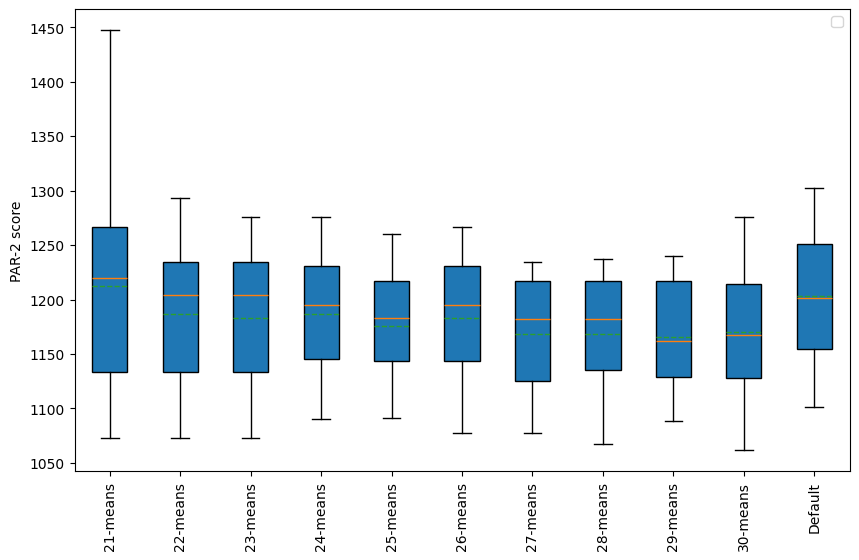

[1212.4765064394787,
 1187.008366490822,
 1183.3599958953105,
 1186.3074251943513,
 1176.1294829646224,
 1182.9385442096936,
 1168.0710021348375,
 1168.756187637072,
 1165.8110271055448,
 1170.1791230956192]

In [4]:
import pickle
from helpers import *

results = []

for i in range(21, 31):
    with open('clustminhitset/cminhit_{}means.pkl'.format(i), 'rb') as f:
        results.append(pickle.load(f))

results = [x[:10] for x in results]
print(len(results[0]))
compareModels(results, ["{}-means".format(i) for i in range(21,31)], default=True)